In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow.compat.v1 as tf

from tqdm import tqdm
from tensorflow.python.framework import ops
from tqdm import tqdm_notebook
from scipy.spatial.distance import hamming, cosine, euclidean

%matplotlib inline

In [2]:
def image_loader(image_path, image_size):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    
    return image

In [3]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    
    with open(labels_file_path, "r") as f:
        classes = f.read().split("\n")[:-1]
        
        images = []
        labels = []
        image_paths = []
        
        for image_name in os.listdir(dataset_path):
            try:
                image_path = os.path.join(dataset_path, image_name)
                images.append(image_loader(image_path, image_size))
                image_paths.append(image_path)
                
                for idx in range(len(classes)):
                    if classes[idx] in image_name:
                        labels.append(idx)
            except:
                pass
        
        with open(image_paths_pickle + ".pickle", "wb") as f:
            pickle.dump(image_paths, f)
        
        print(len(images))
        print(len(labels))
        
        assert len(images) == len(labels)
        
        return np.array(images), np.array(labels)

In [525]:
images, labels = dataset_preprocessing("plant/train","plant/labels.txt",(224,224),"training_images_pickle")

4323
4323


In [526]:
images.shape

(4323, 224, 224, 3)

In [4]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i],query_vector[0]))
   
    return np.argsort(distances)[:top_n]

In [5]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i],query_vector[0]))
    
    return np.argsort(distances)[:top_n]

In [6]:
def sparse_accuracy(true_labels, predicted_labels):
    
    assert len(true_labels) == len(predicted_labels)
    correct = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct += 1
            
    return correct/len(true_labels)

In [7]:
def model_inputs(image_size):
    tf.disable_v2_behavior()

    inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size[0], image_size[1], 3], name='images')
    targets = tf.placeholder(dtype=tf.int32, shape=[None,], name='targets')
    dropout_prob = tf.placeholder(dtype=tf.float32, name='dropout_probs')
    
    return inputs, targets, dropout_prob

In [8]:
def conv_block(inputs, 
               number_of_filters, 
               kernel_size, 
               strides=(1, 1), 
               padding='SAME', 
               activation=tf.nn.relu, 
               max_pool=True, 
               batch_norm=True):

    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding, 
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer, 
                                        pool_size=(2, 2), 
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, conv_features

In [9]:
def dense_block(inputs, 
                units, 
                activation=tf.nn.relu, 
                dropout_rate=None, 
                batch_norm=True):
    
    dense_features = layer = tf.layers.dense(inputs, 
                                             units=units, 
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer, rate=dropout_rate)
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, dense_features

In [10]:
def opt_loss(logits, 
             targets, 
             learning_rate):
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [11]:
class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 image_size, 
                 number_of_classes=5):
        
        ops.reset_default_graph()
        
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
 
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
 
      
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
     
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
    
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
     
    
        flat_layer = tf.layers.flatten(conv_block_4)
        
   
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
       
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
     
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
       
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)
        

In [13]:
model = ImageSearchModel(0.001, (224, 224), 5)

In [14]:
def train(model, 
          epochs,
          drop_rate,
          batch_size, 
          data, 
          save_dir, 
          saver_delta=0.15):
    
    
    X_train, y_train, X_test, y_test = data
    
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    
    best_test_accuracy = 0.0
    
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for ii in tqdm(range(len(X_train) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.targets:y_batch, 
                         model.dropout_rate:drop_rate}
            
            _, t_loss, preds_t = session.run([model.optimizer, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch, preds_t))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),  
              " | Training accuracy: {}".format(np.mean(train_accuracy)), 
              " | Training loss: {}".format(np.mean(train_loss)) )
        
        test_accuracy = []
        
        for ii in tqdm(range(len(X_test) // batch_size)):
            start_id = ii*batch_size
            end_id = start_id + batch_size
            
            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, 
                         model.dropout_rate:0.0}
            
            preds_test = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, preds_test))
            
        print("Test accuracy: {}".format(np.mean(test_accuracy)))
        
        if np.mean(train_accuracy) > np.mean(test_accuracy): 
            #if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta:
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))
                    
    session.close()

In [14]:
epochs = 6
batch_size = 32
learning_rate = 0.001
dropout_probs = 0.6
image_size = (224,224)

In [15]:
X_train, y_train = dataset_preprocessing('plant/train', 'plant/labels.txt', image_size=image_size, image_paths_pickle="saver/train_images_pickle")

4323
4323


In [16]:
X_train.shape

(4323, 224, 224, 3)

In [17]:
X_test, y_test = dataset_preprocessing('plant/test', 'plant/labels.txt', image_size=image_size, image_paths_pickle="saver/test_images_pickle")

968
968


In [18]:
X_test.shape

(968, 224, 224, 3)

In [19]:
model = ImageSearchModel(learning_rate, image_size)

In [20]:
data = (X_train, y_train, X_test, y_test)

In [291]:
train(model, epochs, dropout_probs, batch_size, data, 'saver')

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 0/6  | Training accuracy: 0.7601851851851852  | Training loss: 103142.3828125


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:54<00:00,  1.82s/it]


Test accuracy: 0.18958333333333333


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 1/6  | Training accuracy: 0.8393518518518519  | Training loss: 4.753119468688965


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:54<00:00,  1.81s/it]


Test accuracy: 0.18958333333333333


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 2/6  | Training accuracy: 0.8143518518518519  | Training loss: 24.162357330322266


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:54<00:00,  1.82s/it]


Test accuracy: 0.18958333333333333


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 3/6  | Training accuracy: 0.825  | Training loss: 1.2197539806365967


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.93s/it]


Test accuracy: 0.18958333333333333


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 4/6  | Training accuracy: 0.6439814814814815  | Training loss: 1.3663312196731567


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:55<00:00,  1.85s/it]


Test accuracy: 0.18958333333333333


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch: 5/6  | Training accuracy: 0.6569444444444444  | Training loss: 1.193111538887024


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:54<00:00,  1.82s/it]


Test accuracy: 0.18958333333333333
Instructions for updating:
Use standard file APIs to delete files with this prefix.


In [469]:
def create_training_set_vectors(model, 
                                X_train, 
                                y_train,
                                batch_size,
                                checkpoint_path, 
                                image_size, 
                                distance='hamming'):
    
    
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []

    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, 
                     model.dropout_rate:0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('saver/hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('saver/cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)

In [470]:
model = ImageSearchModel(learning_rate, image_size)

In [471]:
create_training_set_vectors(model, X_train, y_train, batch_size, "saver/model_epoch_1.ckpt", image_size)

INFO:tensorflow:Restoring parameters from saver/model_epoch_1.ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [03:54<00:00,  1.74s/it]


In [21]:
def create_training_set_vectors_with_colors(model, 
                                            X_train, 
                                            y_train,
                                            batch_size,
                                            checkpoint_path, 
                                            image_size, 
                                            distance='hamming'):
    
            
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    color_features = []
    for img in X_train:
        channels = cv2.split(img)
        features = []
        for chan in channels:
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            features.append(hist)
            
        color_features.append(np.vstack(features).squeeze())
  
    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, 
                     model.dropout_rate:0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1) #binarize vectors
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open('saver/hamming_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
   
    elif distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('saver/cosine_train_vectors.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)
            
    
    with open('saver/color_vectors.pickle', 'wb') as f:
        pickle.dump(color_features[:len(training_vectors)], f)
    

In [22]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

In [23]:
create_training_set_vectors_with_colors(model, X_train, y_train, batch_size, 'saver/model_epoch_2.ckpt', image_size)

INFO:tensorflow:Restoring parameters from saver/model_epoch_2.ckpt


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [05:18<00:00,  2.36s/it]


In [24]:
def compare_color(color_vectors, 
                  uploaded_image_colors, 
                  ids):
    
    color_distances = []
    
    for i in range(len(color_vectors)):
        color_distances.append(euclidean(color_vectors[i], uploaded_image_colors))
        
    return ids[np.argsort(color_distances)[:15]] 

In [25]:
def simple_inference(model, 
                     session,
                     train_set_vectors, 
                     uploaded_image_path,
                     image_size, 
                     distance='hamming'):
    
    image = image_loader(uploaded_image_path, image_size)
    channels = cv2.split(image)
    features = []
    
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [26]:
def simple_inference_with_color_filters(model, 
                                         session,
                                         train_set_vectors, 
                                         uploaded_image_path,
                                         color_vectors,
                                         image_size, 
                                         distance='hamming'):
    
    
    image = image_loader(uploaded_image_path, image_size)
    
    channels = cv2.split(image)
    features = []
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)

        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    elif distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
        closest_ids = compare_color(np.array(color_vectors)[closest_ids], color_features, closest_ids)
        
    return closest_ids

In [27]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [28]:
saver = tf.train.Saver()
saver.restore(session, "saver/model_epoch_2.ckpt")

INFO:tensorflow:Restoring parameters from saver/model_epoch_2.ckpt


In [29]:
with open('saver/train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [30]:
train_image_paths[:10]

['plant/train\\daisy (1).jpg',
 'plant/train\\daisy (10).jpg',
 'plant/train\\daisy (100).jpg',
 'plant/train\\daisy (101).jpg',
 'plant/train\\daisy (102).jpg',
 'plant/train\\daisy (103).jpg',
 'plant/train\\daisy (104).jpg',
 'plant/train\\daisy (105).jpg',
 'plant/train\\daisy (106).jpg',
 'plant/train\\daisy (107).jpg']

In [31]:
with open('saver/hamming_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [32]:
with open('saver/color_vectors.pickle', 'rb') as f:
    color_vectors = pickle.load(f)

In [129]:
test_image = 'plant/train/sunflower (52).jpg'

In [130]:
result_ids = simple_inference_with_color_filters(model, session, train_set_vectors, test_image, color_vectors, image_size, distance='hamming')

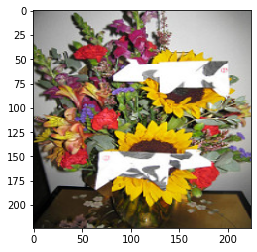

In [131]:
plt.imshow(image_loader(test_image, image_size))

plant/train\sunflower (126).jpg


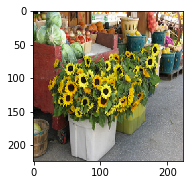

In [133]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
colums = 5
rows = 5
for i in range(2):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, colums, i)
        print(train_image_paths[result_ids[1]])
        plt.imshow(image)
    except:
        pass
plt.show()

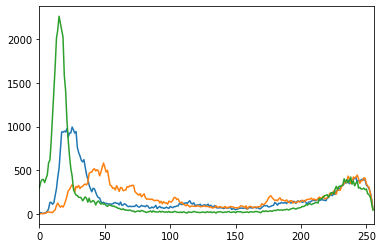

In [355]:
chans = cv2.split(X_train[0])
features = []
for chan in chans:
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.append(hist)
    
    plt.plot(hist)
    plt.xlim([0, 256])

In [356]:
np.array(features).shape

(3, 256, 1)

In [82]:
np.vstack(features).squeeze()

array([1.000e+00, 1.700e+01, 5.000e+00, 9.000e+00, 6.000e+00, 1.700e+01,
       3.100e+01, 5.900e+01, 1.330e+02, 1.310e+02, 1.100e+02, 1.270e+02,
       2.080e+02, 2.890e+02, 4.180e+02, 5.220e+02, 7.380e+02, 9.390e+02,
       9.350e+02, 9.470e+02, 9.380e+02, 9.750e+02, 8.810e+02, 9.250e+02,
       9.270e+02, 9.940e+02, 9.620e+02, 9.250e+02, 9.430e+02, 7.590e+02,
       7.010e+02, 6.630e+02, 6.140e+02, 5.950e+02, 6.210e+02, 5.370e+02,
       4.490e+02, 3.990e+02, 3.280e+02, 2.880e+02, 2.530e+02, 2.930e+02,
       2.880e+02, 2.490e+02, 2.090e+02, 1.870e+02, 1.830e+02, 1.410e+02,
       1.250e+02, 1.330e+02, 1.210e+02, 1.220e+02, 1.150e+02, 1.150e+02,
       1.130e+02, 1.120e+02, 1.150e+02, 1.260e+02, 1.300e+02, 1.210e+02,
       1.220e+02, 1.030e+02, 1.360e+02, 9.900e+01, 1.030e+02, 1.160e+02,
       1.090e+02, 9.200e+01, 8.200e+01, 8.900e+01, 8.400e+01, 8.600e+01,
       8.500e+01, 8.700e+01, 1.040e+02, 8.800e+01, 7.700e+01, 8.300e+01,
       9.800e+01, 8.900e+01, 9.000e+01, 8.200e+01, 